## Постановка задачи

Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

#### Описание данных

Данные представляют собой набор изображений, рассортированных по папкам. Название папки соответствует музыкальному жанру. Представлены следующие жанры: anime, black metal, classical, country, disco, edm, jazz, pop, rap, reggae

#### Pipeline решения

- Составить csv-таблицу со списком файлов и целевой переменной
- Анализ данныз (выявление проблем)
- Преобразование данных в эмбеддинги и подготовка данных
- Решение с помощью поиска ближайших соседей
- Решение с помощью использования стандартных моделей
- Решение с помощью fastai

## Загрузка и анализ данных

Загрузим нужные модули

In [1]:
import os
import faiss
import pandas as pd
from PIL import Image

from tqdm.notebook import tqdm
import ipyplot
from IPython.core.display import  HTML

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from PIL import ImageEnhance 

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from fastai.vision.all import *

import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import v2
import torch.nn as nn
import numpy as np

import torchvision

Определим константы. <br>
DATA_PATH - директория с данными (в ней находятся папки с обложками для альбомов)<br>
MAKE_EMBEDDINGS - константа, отвечающая за то, нужно ли превращать картинки в эмбеддинги. Если значение True - то да, иначе загружает из приготовленного заранее датасета.<br>
DIM - длина эмбеддингов<br>
AUGMENTATION - содержит все возможные аугментации картинок<br>

In [2]:
DATA_PATH = "./data/"
MAKE_EMBEDDINGS = True
DIM = 2048
AUGMENTATION = ['ORIGINAL', 'flip','bri_2', 'bri_0.5', 'color', 'gray']

Сначала получим список музыкальных стилей. Для этого получим список папок.

In [3]:


style_list = []
for root, dirs, files in os.walk(DATA_PATH, topdown=False):
    #Ищем все папки внутри папки с данными и запоминам названия
    for name in dirs:
        style_list.append(name)
        

print(style_list)


['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']


Инициализируем датафрейм с названиями файлов. В нём будут записаны полные пути (относительно папки с проектом), названия, расширения и целевая переменная.

In [4]:
df_files = pd.DataFrame(columns = ['file_path','name','ext','target'])


Запишем данные в датасет

In [5]:
# Перебираем все папки
for i in style_list:
    #Указываем путь до нужной папки
    directory = DATA_PATH + i
    for f in os.listdir(directory):
        #Определяем путь до искомого файла
        file_path = directory + '/' + f 
        #Определяем расширение файла
        f_ext = f[-3:]
        #Записываем всё в таблицу
        df_files = pd.concat([pd.DataFrame([[file_path, f,f_ext,i]], columns=df_files.columns), df_files], ignore_index=True)
        

Смотрим на получившийся результат

In [6]:
df_files

,file_path,name,ext,target
0,./data/reggae/fd147614-feea-47e0-96f4-530912a5bf2c.png,fd147614-feea-47e0-96f4-530912a5bf2c.png,png,reggae
1,./data/reggae/fbc4a706-adc3-4f73-a632-e766bc7fba8e.png,fbc4a706-adc3-4f73-a632-e766bc7fba8e.png,png,reggae
2,./data/reggae/fbc14ad1-cf7d-446d-970e-07ddf0dabeb7.png,fbc14ad1-cf7d-446d-970e-07ddf0dabeb7.png,png,reggae
3,./data/reggae/fb9530d1-039d-471f-b4bb-ddfa700b77f3.png,fb9530d1-039d-471f-b4bb-ddfa700b77f3.png,png,reggae
4,./data/reggae/f7234528-903a-4b4f-a19f-2a87d60db665.png,f7234528-903a-4b4f-a19f-2a87d60db665.png,png,reggae
...,...,...,...,...
7549,./data/anime/00ec64ef-c6ab-4a63-91df-59ce8db4ea25.png,00ec64ef-c6ab-4a63-91df-59ce8db4ea25.png,png,anime
7550,./data/anime/00ddb3de-75db-4e27-ad3d-441a5dc95636.png,00ddb3de-75db-4e27-ad3d-441a5dc95636.png,png,anime
7551,./data/anime/00a9d688-337f-4807-83cd-596540f1683b.png,00a9d688-337f-4807-83cd-596540f1683b.png,png,anime
7552,./data/anime/0091bee3-a67a-457e-8c5f-b4a1055b1211.png,0091bee3-a67a-457e-8c5f-b4a1055b1211.png,png,anime


Таблица успешно создана

### Анализ данных

Проверим, у всех ли изображений одинаковое расширение?

In [7]:
df_files.ext.unique()

array(['png'], dtype=object)

Как видим, у всех изображений одинаковые расширения. Теперь посмотрим на баланс классов.

In [8]:
df_files_bar = df_files.target.value_counts().sort_values(ascending = False)

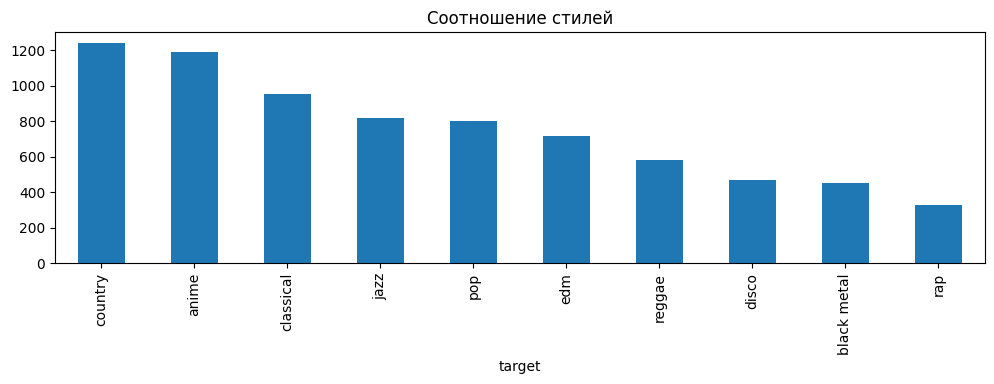

In [9]:
df_files_bar.plot.bar(figsize = (12,3), title = 'Соотношение стилей');

Мы наблюдаем явный дисбаланс классов. Однако, было принято решение оставить этот дисбаланс. Теперь нам нужно проверить, у всех ли изображений одинаковые размеры?

In [10]:
#Добавим в датасет колонки с высотой и шириной изображения
df_files['width'] = 0
df_files['height'] = 0

In [11]:
#Пройдёмся по датасету
for i in tqdm(range(len(df_files))):
    #Путь к конкретному файлу
    file_path = df_files.iloc[i]['file_path'] 
    #Открываем изображение и считываем его размеры
    im = Image.open(file_path)
    width, height = im.size
    #Записываем размеры в наш датасет
    df_files.at[i,'width'] = width
    df_files.at[i,'height'] = height

  0%|          | 0/7554 [00:00<?, ?it/s]

Проверяем все ли изображения имеют одинаковые размеры?

In [12]:
df_files.width.unique(), df_files.height.unique()

(array([300], dtype=int64), array([300], dtype=int64))

Как видим, все изображения имеют одинаковые размеры 300 на 300. Теперь выведем по 10 изображений для каждого музыкального стиля и оценим визуально.

In [13]:
#Перебираем все стили
for i in style_list:
    df_temp = df_files.query('target == @i').head(10)
    #Инициализируем список изображений
    img = []
    for i2 in df_temp['file_path']:
        img.append(i2)
    #Пишем заголовок для каждого стиля
    display(HTML('<h1>'+i+'</h1>'))
    #Выводим изображения
    ipyplot.plot_images(img, img_width=150)

### Вывод

Мы загрузили и проанализировали данные. Проблем, кроме дисбаланса, не обнаружено. Проверка на дубликаты не была произведена в связи со структурой данных. Также были выведены изображения. Судя по тем обложкам альбомов, которые были выведены, изображения действительно соответствуют заданным жанрам.

## Создание эмбеддингов

In [14]:
#Запишем одну картинку для дальнейшего тестирования в переменную
test_img = df_files['file_path'].iloc[0]

Для создания эмбеддингов мы будем использовать предобученную модель resnet50. Она использовалась для классификации изображений с 1000 классов. Мы уберём последний слой (с предсказаниями для тех классов) и в качестве векторов будем использовать предыдущий.

In [15]:
#Подгрузим модель
resnet_50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#Уберём последний слой
layers = list(resnet_50.children())[:-1]
resnet_50 = nn.Sequential(*layers) 
resnet_50.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Напишем вспомогательную функцию, которая будет переводить изображение в тензор для дальнейшего превращения его в вектор

In [16]:
image_transform  = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                         std=(0.229, 0.224, 0.225)) ])

Напишем вспомогательную функцию, которая будет превращать тензор, который также получается при использовании модели,  в список для записи в датафрейм

In [17]:
def tensor_to_list(tensor_):
    tensor_ = tensor_.tolist()
    list_ = []
    for i in tensor_[0]:
        list_.append(i[0][0])
    return list_

Напишем функцию, которая приготовит саму картинку для обработки моделью. Также мы добавим в неё возможность аугментирования - то есть изменения изображения. Всего таких возможности 4: ничего не делать, прибавить яркость, убавить яркость, отразить.

In [18]:
def prepare_img(img_path, #путь к изображению
                augment = 'None' #Применемая аугментация
                ):
    #Открываем изображение и конвертируем в RGB
    v_img = Image.open(img_path).convert('RGB')
    #Придаём изображению нужный размер
    size = 224, 224
    v_img.thumbnail(size)
    #В случае, если мы хотим применить аугметирование, то в зависимости от параметра применяем:
    match augment:
        case 'bri_2': #Прибавление яркости
            curr_bri = ImageEnhance.Brightness(v_img) 
            new_bri = 2
            v_img = curr_bri.enhance(new_bri) 
        case 'bri_0.5': #Уменьшение яркости
            curr_bri = ImageEnhance.Brightness(v_img) 
            new_bri = 0.5
            v_img = curr_bri.enhance(new_bri) 
        case 'flip': #Отражение
            v_img = v_img.transpose(Image.FLIP_LEFT_RIGHT)
        case 'color': #Насыщенность
            curr_col = ImageEnhance.Color(v_img ) 
            new_col = 2.5
            v_img  = curr_col.enhance(new_col) 
        case 'gray': #Чёрнобелый
            curr_col = ImageEnhance.Color(v_img ) 
            new_col = 0
            v_img  = curr_col.enhance(new_col) 
  
  
    return v_img

Напишем функцию, которая превращает картинку в вектор.

In [19]:
def make_vector(img #картинка (НЕ путь до неё)
                ):
    #трансформируем картинку в тезор
    t_img = image_transform(img)
    #возвращаем готовый вектор
    return tensor_to_list(resnet_50(t_img.unsqueeze(0)))

Проверим работу функции

In [20]:
#Превратим в вектор тестовое изображение без аугментации
new_test_img = prepare_img(test_img)
print(make_vector(new_test_img))
#С аугментацией
new_test_img = prepare_img(test_img, 'flip')
print(make_vector(new_test_img))


[0.23116543889045715, 2.7735249996185303, 0.24235834181308746, 0.4670439064502716, 0.40215596556663513, 0.2633278965950012, 1.787772297859192, 0.15405622124671936, 0.09060608595609665, 0.3865930140018463, 0.9199037551879883, 1.0337821245193481, 0.24887439608573914, 0.37002062797546387, 1.0416218042373657, 0.18031959235668182, 0.6037032604217529, 0.6191831231117249, 0.2391790896654129, 0.18965975940227509, 0.09759825468063354, 0.11715950071811676, 0.23839981853961945, 0.27572008967399597, 0.2932501435279846, 0.1294676512479782, 0.5687655210494995, 0.13709942996501923, 0.8407499194145203, 0.23564645648002625, 0.3166913688182831, 1.1420819759368896, 0.26177817583084106, 2.6426734924316406, 0.7677996754646301, 0.1983659714460373, 0.267341673374176, 0.28056901693344116, 0.4008360803127289, 0.2216050922870636, 0.19148026406764984, 1.045443058013916, 0.3338352143764496, 0.45920267701148987, 0.13925057649612427, 0.14945264160633087, 0.19876767694950104, 1.5435112714767456, 0.0395846888422966, 

Как видим, мы успешно превратили изображение в вектор. Вектора отличаются, следовательно аугментация работает. 

#### Запись эмбеддингов в датасет
Сохраним наши эмбеддинги в датасет

In [21]:

if MAKE_EMBEDDINGS == True: #Проверим нужно ли нам это делать, или у нас уже есть записанные эмбеддинги?
    for Augment in tqdm(range(len(AUGMENTATION))): 
        #Мы пройдёмся по датасету несколько раз, каждый раз применяя к картинке аугментацию (или не применяя). 
        #В датасете будут записаны все вариации, однако это не приведёт к утечке данных, так как будет учтено в функции, разделяющей выборки на тестовую и обучающую.

        #Инициализируем список векторов
        embeddings = []
        #Инициализируем временный датасет
        df_embeddings = df_files.copy()
        #Добавляем колонку,  указывающую, какая именно аугментация была применена
        df_embeddings['aug'] = AUGMENTATION[Augment]
        #Проходимся по датасету, в котором пока хранятся ссылки на файлы
        for i in tqdm(range(len(df_embeddings))):
            #Готовим изображение в данной строке с применением аугментации (или её отсутствие)
            image_to_vectorize = prepare_img(df_embeddings['file_path'].iloc[i],AUGMENTATION[Augment])
            #Превращаем картинку в вектор
            embedding = make_vector(image_to_vectorize)
            #Добавляем вектор в список
            embeddings.append(embedding)
        #Преобразуем список векторов в датафрейм
        df_temp = pd.DataFrame(embeddings)
        #Объединяем его с нашим датафреймом
        df_embeddings = pd.merge(df_embeddings, df_temp, left_index=True, right_index=True)
        #Удалим из памяти временный датафрейм
        del df_temp
        
        #Присоединим получившийся датасет к финальному. Если проходимся первый раз, то наш датасет и станет основой финального.
        if Augment == 0:
            df_embeddings_final = df_embeddings.copy()
        else: 
            df_embeddings_final = pd.concat([df_embeddings_final, df_embeddings])
        #Удаляем временный датасет
        del df_embeddings
    #Запишем получившийся датасет    
    df_embeddings_final.to_csv('df_embeddings.csv', index=True, index_label='old_index')  

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/7554 [00:00<?, ?it/s]

Теперь считаем наш результат. Вне зависимости от того, создаём мы его или считываем готовый, мы откроем получившийся файл и посмотрим на результат.

In [22]:
df_embeddings = pd.read_csv('df_embeddings.csv')
df_embeddings.head(3)

,old_index,file_path,name,ext,target,width,height,aug,0,1,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,./data/reggae/fd147614-feea-47e0-96f4-530912a5bf2c.png,fd147614-feea-47e0-96f4-530912a5bf2c.png,png,reggae,300,300,ORIGINAL,0.231165,2.773525,...,0.841615,0.423626,0.025602,0.249285,0.286049,0.141052,0.592688,0.294061,0.167072,0.088828
1,1,./data/reggae/fbc4a706-adc3-4f73-a632-e766bc7fba8e.png,fbc4a706-adc3-4f73-a632-e766bc7fba8e.png,png,reggae,300,300,ORIGINAL,0.078925,1.383880,...,0.459080,0.016277,0.233912,0.144104,0.091781,0.047797,0.259894,0.018200,0.095567,0.162133
2,2,./data/reggae/fbc14ad1-cf7d-446d-970e-07ddf0dabeb7.png,fbc14ad1-cf7d-446d-970e-07ddf0dabeb7.png,png,reggae,300,300,ORIGINAL,0.118199,2.098502,...,0.896913,0.476231,0.345617,0.658896,0.502629,0.461002,0.558537,0.258287,0.200196,0.461722


#### Вывод 

Мы успешно преобразовали изображения в эмбеддинги. Теперь приступим к обучению моделей.

## Обучение моделей

Обучим несколько моделей. В качестве основных метрик будет f1 и accuracy

### Подготовка данных
Мы получили датасет с векторным представлением изображений, но мы не можем его использовать в таком виде. Нам нужно разделить изображение на тестовую и обучающую выборки, причём таким образом, чтобы одинаковые изображения, но с разными аугментациями не попадали бы в разные выборки. Т.е. если изображение без аугментации находятся в обучающей выборке, то и все его вариации должны быть в ней. В тестовой выборке будут только оригинальные изображения. 

Кроме того, мы добавим возможность работать с изображениями ограниченного числа стилей, чтобы посмотреть как модель работает не только на полном датасете, но и на датасете, скажем, только с двумя или тремя стилями.



In [23]:
#Для начала создадим датасет, в котором будут только изображения без аугментации
df_embeddings_clear = df_embeddings.query('aug	== "ORIGINAL"') #Оригинал означает отсутствие аугментации

Напишем функцию для разбиение выборки

In [24]:
def prepare_data(
        dataset = df_embeddings_clear, # Датасет без аугментации
        augs = ['ORIGINAL'], #То, какие аугментации мы будем применять в данном конкретном случае
        styles = style_list):
    #Инициализируем Х и у. Пока нам не надо выбирать столбцы, но для встроенной функции нужно чтобы было два датасета.
    X = dataset
    y = dataset
    #Разделяем их на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.2)
    #Собираем индексы тренировочной выборки
    X_train_idx = list(X_train['old_index'])
    #В тренировочной выборке будут все данные соответсвующих индексов, записанных в датасете (т.е. будут дубликаты с одними и теми же картинками, но поразному аугментированными)
    #В тренировомную выборку попадут те строки, в которых индексы (записанные в датасет, в нашем случае они как признак) будут соответствовать таким из "чистого" датасета
    X_train = df_embeddings.query('old_index in @ X_train_idx')
    #В целевом столбце будут те же строки
    y_train = X_train.copy()
    #Выберем только те стили, которые мы будем анализировать (по умолчанию это все стили)
    X_train = X_train.query('target in @styles and aug in @augs')
    y_train = y_train.query('target in @styles and aug in @augs')
    #Для тестовой выборки мы не применяем аугментацию, так что оставляем то, что мы получили из "чистого" датасета, однако при анализе мы всё равно будем учитывать стили
    X_test = X_test.query('target in @styles')
    y_test = y_test.query('target in @styles')
    #Теперь, наконец, оставляем только нужные столбцы
    X_train = X_train.drop(columns = ['old_index','file_path','name','ext','target','width','height', 'aug'])
    y_train = y_train['target']
    X_test = X_test.drop(columns = ['old_index','file_path','name','ext','target','width','height', 'aug'])
    y_test = y_test['target']
    #Обнуляем индексы (необходимо для поиска соседей)
    X_train.reset_index(drop=True,inplace = True)
    y_train.reset_index(drop=True,inplace = True)
    #Возвращаем результат
    return X_train, X_test, y_train, y_test

### Поиск ближайших соседей с помощью faiss
Опробуем метод поиска ближайших соседей. Мы будем искать все похожие вектора в тренировочной выборке и методом голосования определять, к какому жанру относится наше изображение. Т.е. если наше изображение похоже на изображения в жанре аниме, то оно, скоро всего тоже относится к этому жанру <br><br>
Для начала напишем вспомогательные функции<br>
Первая функция для пресказания жанра конкретного изображения 

In [25]:
def faiss_predict_vector(input_index,
        vector, #Вектор, который мы анализирем
        y_data, #Даннеы для поиска жанров 
        k_nn = 3, #Количество "соседей" которые мы рассматриваем
          #Индекс faiss
):
    #Ищем вектора в индексе
    D, I =input_index.search(vector, k_nn)
    #Переводим индексы в список
    I = I .tolist()[0]
    #Вместо индексов получаем конкретные значения жанров
    T = y_data.loc[I]
    T = list(T)
    #Получаем словарь с жанрами и расстояниями до них
    targets  = dict.fromkeys(list(set(T)),0)
    #Считаем "вес" жанров. Весом жанра будет считать сумма единиц делённых на расстояние. Т.е. если у нас есть два соседа одного жанра, то суммарный вес его будет зависеть от расстояния, причём чем выше расстояние
    #тем меньше прибавка
    for i in range(len(T)):
        targets[T[i]] -= 1 / (1+I[i]) #Ещё умножаем на минус единицу, так как так удобней для сортировки
    #Сортируем жанры. Жанр с большим (в данном случае меньшим, т.к. мы умножали на -1) весом будет на первом месте
    targets = sorted(targets.items(), key=lambda x: x[1])
    targets = list(dict(targets))
    #Возвращаем предсказание, т.е. жанр с большим весом
    return targets[0]
    

Напишем функцию, которая будет работать со всем датасетом и выдаст список предсказаний. Эта функция будет промежуточной

In [26]:
def faiss_predict( input_index, x, y_data, k_nn = 3):
    pred = np.array([])
    for i in range(len(x)):
        prediction = faiss_predict_vector(input_index, x.iloc[[i]], y_data, k_nn = k_nn, )
        pred = np.append(pred, prediction)
    return pred

Финальная функция для предсказаний и тестирования метрик

In [27]:
def final_faiss_predict(knn = 4, #Количество соседей
                        dataset = df_embeddings_clear,# "Чистый" датасет
                          augs = ['ORIGINAL'],#Аугментации, которые мы будем применять
                            styles = style_list, #Стили, которые мы будем исследовать
                            ):
    #Подготавливаем данные с учётом выбранных нами параметрами
    X_train, X_test, y_train, y_test = prepare_data(dataset = dataset, augs = augs, styles = styles)
    #Создаём индекс с учётом длины вектора
    index = faiss.IndexFlatL2(DIM)   
    #Создаём индекс для тренировочного датасета (с учётом заданных параметров)
    index.add(X_train)                  
    #Делаем предсказания. Также возвращаем датасеты для тестирования (т.к. мы разбиваем их внутри функции)    
    pred = faiss_predict(index, X_test, y_train, knn)
    return X_train, X_test, y_train, y_test, pred


#### Тестирование faiss

Проверим как работает метод ближайших соседей для разных наборов жанров. 

In [28]:
for i in tqdm(range(1, len(style_list))): #Будем делать предсказания для датасета начиная с двух жанров и далее
    styles_list = style_list[0:i+1] #Создаём список жанров в зависимости от итерации
    print(styles_list)#Выводим список, чтобы видеть какой результат при каких жанрах
    #Делаем предсказание и выводим результат для каждого набора жанров
    X_train, X_test, y_train, y_test, pred = final_faiss_predict(knn = 4, styles = styles_list)
    print(f"F1 Score: {f1_score(y_test, pred, average='weighted')}, accuracy: {accuracy_score(y_test, pred)}")

  0%|          | 0/9 [00:00<?, ?it/s]

['anime', 'black metal']
F1 Score: 0.9474634843711565, accuracy: 0.9465875370919882
['anime', 'black metal', 'classical']
F1 Score: 0.8511613783954477, accuracy: 0.8495238095238096
['anime', 'black metal', 'classical', 'country']
F1 Score: 0.7082379854252481, accuracy: 0.702523240371846
['anime', 'black metal', 'classical', 'country', 'disco']
F1 Score: 0.6464613358682361, accuracy: 0.6254458977407847
['anime', 'black metal', 'classical', 'country', 'disco', 'edm']
F1 Score: 0.6043316768836896, accuracy: 0.5893223819301848
['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz']
F1 Score: 0.509545060574399, accuracy: 0.4890446976336547
['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop']
F1 Score: 0.47254704331078523, accuracy: 0.46019711902956784
['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap']
F1 Score: 0.4580608670913801, accuracy: 0.4371822803195352
['anime', 'black metal', 'classical', 'country', 'dis

Мы видим, что наша модель очень хорошо справляется с двумя жанрами, однако чем больше жанров, тем хуже результаты. На всех жанрах модель даёт результаты F1 Score: 0.43392815404847457, accuracy: 0.4182660489741893
Теперь проверим результаты для разного количества соседей

In [29]:
#Будем запоминать метрики
best_acc = 0
best_knn = 0
best_f1 = 0
#Проверим количество соседей от 1 до 9
for i in tqdm(range(1, 10)):
    #Делаем предсказание
    X_train, X_test, y_train, y_test, pred = final_faiss_predict(knn = i, augs = AUGMENTATION)
    new_acc = accuracy_score(y_test, pred)
    #Выбираем лучшие результаты
    if new_acc > best_acc:
        best_acc = new_acc
        best_f1 = f1_score(y_test, pred, average='weighted')
        best_knn = i
print(f"Best K: {best_knn}, F1 Score: {best_f1}, accuracy: {best_acc}")

  0%|          | 0/9 [00:00<?, ?it/s]

Best K: 1, F1 Score: 0.46420473127070455, accuracy: 0.46657842488418266


Мы видим, что лучшие результаты cаугментированием достигаются при одном соседе - это Best K: 1, F1 Score: 0.46420473127070455, accuracy: 0.46657842488418266. 

In [30]:
for i in tqdm(range(0, len(AUGMENTATION))):
    a_list = AUGMENTATION[0:i+1]
    print(a_list)
    X_train, X_test, y_train, y_test, pred = final_faiss_predict(knn = 1, augs = a_list)
    print(f"F1 Score: {f1_score(y_test, pred, average='weighted')}, accuracy: {accuracy_score(y_test, pred)}")

  0%|          | 0/6 [00:00<?, ?it/s]

['ORIGINAL']
F1 Score: 0.4543944776894014, accuracy: 0.4559894109861019
['ORIGINAL', 'flip']
F1 Score: 0.4524253743407512, accuracy: 0.4553275976174719
['ORIGINAL', 'flip', 'bri_2']
F1 Score: 0.4510037288944194, accuracy: 0.45466578424884185
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5']
F1 Score: 0.45483712856933106, accuracy: 0.45797485109199204
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5', 'color']
F1 Score: 0.46467513207885297, accuracy: 0.4672402382528127
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5', 'color', 'gray']
F1 Score: 0.46420473127070455, accuracy: 0.46657842488418266


Агументация действительно позволила немного улучшить результат - F1 Score: F1 Score: 0.46420473127070455, accuracy: 0.46657842488418266, однако это чуть хуже чем если убрать одну аугментацию.

#### Вывод по Faiss

Метод поиска ближайших соседей хорошо показал себя при небольшом наборе жанров, однако на всех жанра результат удручающий - всего 46% точности. Это лучший результат, достигнутый при полной аугментации (т.е. использованы все способы аугментации) и при 1 соседях.

## Модели машинного обучения
Теперь попробуем иной подход - мы обучим обычные модели на наших эмбеддингах и попробуем предсказать результат. В данном случае, это будет логистическая регрессия и CatBoost. 

#### Логистическая регрессия
Любопытно то, что используя логистическую регрессию, мы по сути используем всю нейронную сеть resnet50, но с количеством выходов, соответствующим количеству жанров.

Инициализируем модель

In [31]:
model =  LogisticRegression(n_jobs=3,  
                                           multi_class='multinomial',
                                           max_iter=1000,
                                           random_state=42,
                                           verbose = 0)

Проверим, как она покажет себя на разных наборах жанров

In [32]:
    
#Алгоритм похож на тот, что был в тестировании faiss
for i in tqdm(range(1, len(style_list))):
    styles_list = style_list[0:i+1]
    print(styles_list)
    X_train, X_test, y_train, y_test = prepare_data(styles = styles_list, augs = ['ORIGINAL'])

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, pred, average='weighted')}, accuracy: {accuracy_score(y_test, pred)}")
    

  0%|          | 0/9 [00:00<?, ?it/s]

['anime', 'black metal']
F1 Score: 0.96448647250662, accuracy: 0.9643916913946587
['anime', 'black metal', 'classical']
F1 Score: 0.9257439199170948, accuracy: 0.9257142857142857
['anime', 'black metal', 'classical', 'country']
F1 Score: 0.8341945283802863, accuracy: 0.8339973439575034
['anime', 'black metal', 'classical', 'country', 'disco']
F1 Score: 0.7755736697787403, accuracy: 0.7752675386444708
['anime', 'black metal', 'classical', 'country', 'disco', 'edm']
F1 Score: 0.7345188945764486, accuracy: 0.7340862422997947
['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz']
F1 Score: 0.6523958955769433, accuracy: 0.6538124452234881
['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop']
F1 Score: 0.615560277519982, accuracy: 0.6171341925701289
['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap']
F1 Score: 0.5998916860220257, accuracy: 0.6005809731299927
['anime', 'black metal', 'classical', 'country', 'disco'

Как видим, картина похожа на поиск по соседям, однако, результат заведомо лучше. F1 Score: 0.5831854494836038, accuracy: 0.5837193911317009
Посмотрим, как проявит себя аугментация на всех жанрах.

In [33]:
model =  LogisticRegression(n_jobs=3,  
                                           multi_class='multinomial',
                                           max_iter=1000,
                                           random_state=42,
                                           verbose = 0)

In [34]:
    
for i in tqdm(range(0, len(AUGMENTATION))):
    a_list = AUGMENTATION[0:i+1]
    print(a_list)
    X_train, X_test, y_train, y_test = prepare_data(styles = style_list, augs = a_list)

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, pred, average='weighted')}, accuracy: {accuracy_score(y_test, pred)}")


  0%|          | 0/6 [00:00<?, ?it/s]

['ORIGINAL']
F1 Score: 0.5831854494836038, accuracy: 0.5837193911317009
['ORIGINAL', 'flip']
F1 Score: 0.5805262592081913, accuracy: 0.5797485109199206
['ORIGINAL', 'flip', 'bri_2']
F1 Score: 0.5599089270976928, accuracy: 0.5592322964923891
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5']
F1 Score: 0.5729165981134468, accuracy: 0.57180675049636
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5', 'color']
F1 Score: 0.5709481603623352, accuracy: 0.57114493712773
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5', 'color', 'gray']
F1 Score: 0.5625238083310901, accuracy: 0.5612177365982793


Мы видим, что аугментация скорее мешает логистической регрессии. Лучший результат для регрессии  F1 Score: 0.583, accuracy: 0.583

#### CatBoost

Посмотрим, как проявит себя CatBoost. Мы будем сразу тестировать его на всех стилях и посмотрим как модель проявит себя при разных аугментациях.

In [35]:
for i in tqdm(range(0, len(AUGMENTATION))):
    a_list = AUGMENTATION[0:i+1]  
    print(a_list)
    X_train, X_test, y_train, y_test = prepare_data(styles = styles_list, augs = a_list)
    model = CatBoostClassifier(task_type='GPU', iterations = 200,
                               eval_metric='TotalF1', depth = 6, learning_rate = 0.3, silent = True
                               )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, pred, average='weighted')}, accuracy: {accuracy_score(y_test, pred)}")


  0%|          | 0/6 [00:00<?, ?it/s]

['ORIGINAL']
F1 Score: 0.5761914102989253, accuracy: 0.5810721376571807
['ORIGINAL', 'flip']
F1 Score: 0.5714716038878708, accuracy: 0.5744540039708802
['ORIGINAL', 'flip', 'bri_2']
F1 Score: 0.57064690018849, accuracy: 0.5744540039708802
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5']
F1 Score: 0.5680790991393804, accuracy: 0.57114493712773
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5', 'color']
F1 Score: 0.5723750457530663, accuracy: 0.5771012574454004
['ORIGINAL', 'flip', 'bri_2', 'bri_0.5', 'color', 'gray']
F1 Score: 0.5600062515104987, accuracy: 0.5651886168100596


Как мы видим, CatBoost справился немного хуже логистической регрессии. Впрочем, этот результат ожидаем, учитывая специфику данных.

#### Вывод по моделям

Логистическая регрессия показала себя лучше поиска по ближайшим соседям. Показатели F1 Score: 0.583, accuracy: 0.583 без аугментации. 


## FastAI
Проверим теперь fastai. Для модели не требуется заранее создавать эмбеддинги, она всё делает автоматически. Для начала инициализируем DataLoader

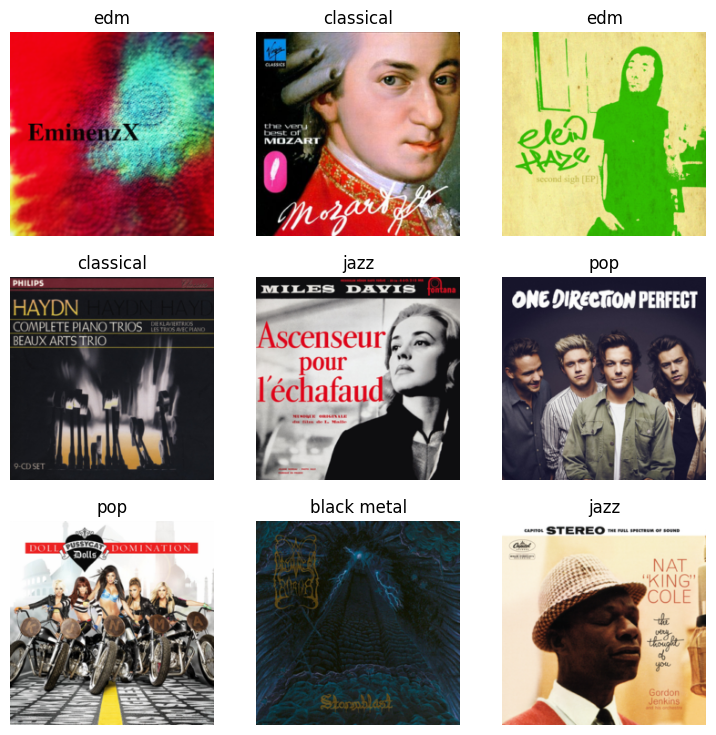

In [36]:
#Инициализируем даталоадер
dls = ImageDataLoaders.from_folder('data/', valid_pct=0.2, item_tfms=Resize(224))
#Покажем батч
dls.show_batch()


Теперь обучим модель. Поскольку она автоматически разбивает датасет на тренировочную и валидационную выборки, мы можем доверять её результатам.

SuggestedLRs(valley=0.0014454397605732083)

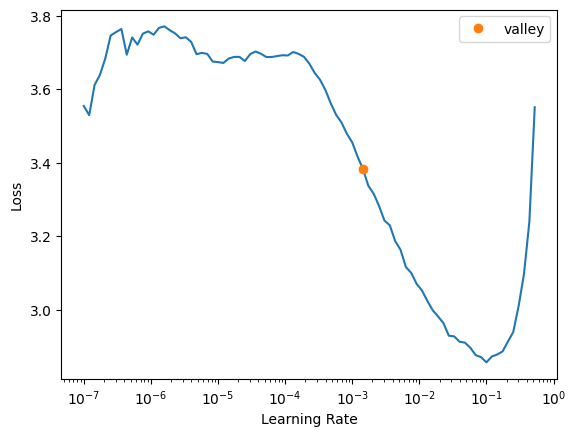

In [37]:
learn = vision_learner(dls, resnet50, metrics=[accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')], model_dir='models', weights=ResNet50_Weights.DEFAULT)
learn.lr_find()


In [38]:
learn.fine_tune(5, base_lr= 0.020
)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.939567,1.652175,0.532450,0.537370,0.532450,0.521241,15:29


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.235855,1.427956,0.615894,0.621649,0.615894,0.601999,19:18
1,1.069373,1.231420,0.607947,0.634414,0.607947,0.603864,19:15
2,0.735784,1.077672,0.673510,0.693156,0.673510,0.675985,19:19
3,0.279439,1.108482,0.690728,0.699154,0.690728,0.688760,19:06
4,0.084281,1.106419,0.701325,0.704931,0.701325,0.696357,18:51


Как мы видим, лучших результатов модель достигла при обучении на трёх эпохах. Этот результат 70%, что лучше предыдущих моделей. Посмотрим на матрицу ошибок.

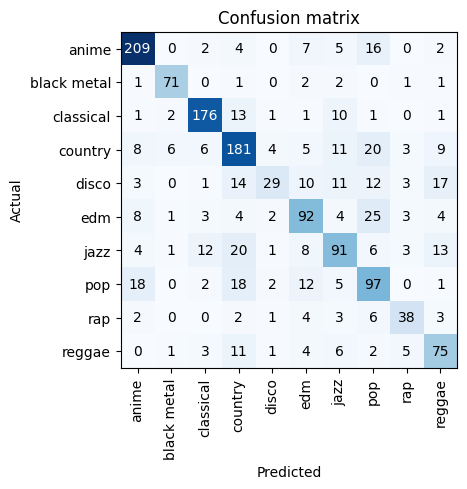

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Мы можем наблюдать, что у модели есть слабые места.Она часто пытается предсказать кантри и поп там, где это не надо.

## Общий вывод
Мы проанализировали данные на проблемы и не обнаружили их. В качестве метрики был выбран accuracy и f1.
Мы использовали несколько методов для определения стиля альбома по обложке. 
Кроме того, мы использовали аугментацию - то есть, создание дублирующих изображений с изменёнными параметрами яркости и отражённых.

Для обучения моделей и поиска ближайших соседей были использованы эмбеддинги, созданные при помощи предобученной модели resnet50. <br>
Поиск по ближайшим соседям с помощью faiss показал слабый результат, однако аугментация улучшила его. Возможно, дополнительная аугментация смогла бы ещё больше улучшить результат.<br>
Среди моделей лучше всего показала себя логистическая регрессия. На всех жанрах она показала результат F1 Score: 0.583, accuracy: 0.583 без аугментации. CatBoost показал результат хуже. <br>
<br>
Была дообучена модель resnet50 с помощью модуля fastai. Она показала лучший результат - 70% accuracy, однако её недостаток в том, что её обучение требует больших вычислительных мощностей.

Также заметим, что все методы (кроме fastai, в этом плане она не проверялась) показали гораздо лучшие результаты при меньшем количестве жанров. 

